# Introduction

In [19]:
import os
import sys
import csv
import datetime
import umap
import pandas as pd
import xgboost as xgb
import keras
import sklearn
import tensorflow
import numpy as np
import joblib
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tsfresh import extract_features
from matplotlib import pyplot
from keras.models import Model, load_model
from keras.layers import Input, Activation, Dense, concatenate, LSTM, GRU, Dropout
from sklearn import metrics, feature_selection
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from random import uniform, randint

# Data Importation

In [20]:
def import_data():
    dfx = pd.read_csv('../data/x_train.csv').set_index('ID')
    dfy = pd.read_csv('../data/y_train.csv').set_index('ID')
    dfx_test = pd.read_csv('../data/x_test.csv').set_index('ID')
    return dfx, dfy, dfx_test

In [21]:
dfx, dfy, dfx_test = import_data()
dfy.head()
dfx.tail()

,neuron_id,timestamp_0,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6,timestamp_7,timestamp_8,...,timestamp_40,timestamp_41,timestamp_42,timestamp_43,timestamp_44,timestamp_45,timestamp_46,timestamp_47,timestamp_48,timestamp_49
ID,,,,,,,,,,,,,,,,,,,,,
16630,5691,0.077914,0.708334,1.009554,1.125147,1.271336,1.299890,1.666290,1.718390,2.381562,...,29.316422,30.307006,31.185741,31.227892,32.320902,32.701000,32.955075,33.016627,34.837705,34.874491
16631,2341,0.485287,0.870193,0.959064,1.733133,1.755243,1.803468,1.841432,1.986925,2.006145,...,17.151013,17.367892,17.727558,18.178916,18.521734,19.492522,19.515122,20.715555,21.217199,21.640693
16632,8046,0.213619,0.290771,1.575419,1.650658,1.700773,1.856047,1.927563,1.950001,2.367852,...,14.064862,14.092407,14.343008,14.428562,14.671081,14.791297,14.847738,14.916361,15.055357,15.192531
16633,6855,2.669642,7.500198,8.710341,8.724346,8.760471,8.770804,8.786001,8.847625,8.885186,...,15.555430,15.698512,15.782122,16.067267,16.499324,16.906955,17.444176,18.704728,22.082864,27.185064
16634,6921,0.075924,0.376280,0.445379,0.762095,0.929728,1.029945,1.622643,1.710542,2.046901,...,23.397511,23.437452,24.217391,24.519848,24.675594,24.764713,24.894686,25.041824,25.071265,28.288743


In [22]:
if dfy.shape[0] == dfx.shape[0]:
    print("Same number of samples, all good.")
else:
    print("Different number of samples, problem!")

Same number of samples, all good.


# Data Exploration

* **Sanity check:** diff etat1/etat2, neuron_id usefulness

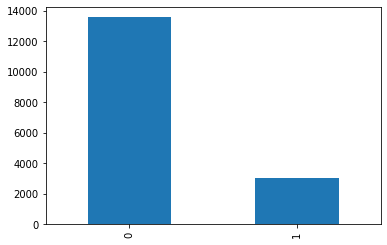

In [23]:
# Différence entre le nombre d'etats 1 et d'etats 0.
dfy.TARGET.value_counts().plot(kind='bar')
plt.show()

In [24]:
# Should we keep the neuron_id col ?
xtest_uniques = dfx_test.neuron_id.unique()
x_uniques = dfx.neuron_id.unique()
diff = [x for x in x_uniques if x in xtest_uniques]
print("There are {} neuron_ids in common between the train and test sets.".format(len(diff)))

There are 1 neuron_ids in common between the train and test sets.


* **Balance dataset:** Choose between undersampling and oversampling, to get equal nb of samples per class

In [25]:
def balance_data(X, y, method="undersampling", **params):
    """ Return balanced training dataset obtained by undersampling class 2. """
    if method == "oversampling":
        sampler = RandomOverSampler(random_state=42)
    elif method == "undersampling":
        sampler = RandomUnderSampler(random_state=42)
    else:
        raise ValueError('Unrecognized sampling method: ', method)

    X, y = sampler.fit_resample(X, y)
    
    return X, y

* **Extract features:** Use tsfresh to perform feature engineering

In [26]:
def extract_tsfresh(X):
    # Create a df with integer names for columns so as to facilitate sorting
    cols = [col for col in range(1, 50)]
    neuron_ids = X[:, 0]
    ts_df = pd.DataFrame(X[:, 1:], columns=cols)
    
    # Stack the df to conform to tsfresh format
    ts_df = pd.DataFrame(ts_df.stack()).reset_index()
    ts_df.columns = ["ID", "timestamp", "spike_time"]
    fe_arr = extract_features(ts_df, column_id="ID", column_value="spike_time", column_sort="timestamp")
    
    # Concatenate into an array, the engineered features df and the time series df
    ts_df = ts_df.pivot(index='ID', columns='timestamp', values='spike_time')
    ts_arr = ts_df.values
    fe_arr = fe_arr.dropna(axis='columns')
    fe_arr = fe_arr.values
    X = np.concatenate((neuron_ids, ts_arr, fe_arr), axis=1)
    
    # Save extracted features
    fname = "../data/features{}.csv".format(datetime.datetime.now().strftime("%m%d%H%M%S"))
    np.savetxt(fname, X, delimiter=",")
    return X

In [27]:
def extract_manual(X):
    neuron_ids = X[:, 0]
    X = X[:, 1:]
    features = np.concatenate((
        np.mean(X, axis=1)[..., np.newaxis],
        np.amin(X, axis=1)[..., np.newaxis],
        np.amax(X, axis=1)[..., np.newaxis]
    ), axis=1)
    quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for q in quantiles:
        features = np.concatenate((features, np.quantile(X, q, axis=1)[..., np.newaxis]), axis=1)
    X = np.concatenate((neuron_ids[..., np.newaxis], X, features), axis=1)
    return X

In [28]:
def isolate_features(X):
    ts_arr = X[:,1:51]
    fe_arr = np.concatenate((X[:,0][..., np.newaxis], X[:,51:]), axis=1)
    return [ts_arr, fe_arr]

* **Feature engineering 2.0:** Add sums from original ts, and groupby neuron_id

In [29]:
def sommes(X, step):
    """
    dfx, dfy, dfx_test = import_data()
    if step == "train":
        df = dfx
    else:
        df = dfx_test
    """    
    somme_tokeep = [10, 20, 30, 40, 50]
    somme = X[:,np.array(somme_tokeep)]
    X = np.concatenate((X, somme), axis=1)
    return X

In [30]:
def group_neurons(fe_arr):
    # Convert fe_arr to DF
    columns = [i for i in range(fe_arr.shape[1])]
    columns[0] = 'neuron_id'
    fe_arr_df = pd.DataFrame(data=fe_arr, columns=columns)
    
    # Groupby neuron_id, compute mean, drop useless neuron_id col, merge df
    neurons_features = fe_arr_df.groupby(['neuron_id']).mean()
    final = fe_arr_df.reset_index().merge(neurons_features, on='neuron_id', sort=False).sort_values('index')
    final = final.values
    return final

* **Remove features with low variance:** pretty self-explanatory

In [31]:
def remove_low_var(X, step="test"):
    if step == "train":        
        X = np.concatenate((X[:,:51], var_sel.fit_transform(X[:,51:])), axis=1)
    else:
        X = np.concatenate((X[:,:51], var_sel.transform(X[:,51:])), axis=1)
    return X

* **Standardization:** Scale features

In [32]:
def standardize_data(X, step="test"):
    """Simple standardization that accepts both a single arr, AND 2 arrays in case of RNN+FeatureEngineering"""
    def standardize(X, step):
        if step == "train":
            return scaler.fit_transform(X)
        else:
            return scaler.transform(X)

    X = np.concatenate((X[:,:51], standardize(X[:,51:], step)), axis=1)
    return X

* **Select Features:** Use sklearn's feature selection module to discard useless features

In [33]:
def get_selection(model_path='../experiments/0626002250/model.h5', nb_fe_tokeep=35):
    model = joblib.load(model_path)
    thresholds = sorted(model.feature_importances_)
    thresh = thresholds[-nb_fe_tokeep]
    feature_sel = sklearn.feature_selection.SelectFromModel(model, threshold=thresh, prefit=True)
    return feature_sel

In [34]:
def select_features(fe_arr, display=False):
    if display:
        pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
        pyplot.show()

    select_fe_arr = feature_sel.transform(fe_arr)
    return select_fe_arr

In [35]:
def custom_split(X, y):
    columns = [i for i in range(X.shape[1])]
    columns[0] = 'neuron_id'
    X = pd.DataFrame(data=X, columns=columns)

    # Sample xyz random neuron_ids
    val_set = np.random.choice(np.unique(X["neuron_id"]), 60, replace=False)
    val_idx = X['neuron_id'].isin(val_set)
    
    # Get X_train y_train, X_val y_val
    X_train = X[~val_idx].values
    X_val = X[val_idx].values
    y_train = y[~val_idx]
    y_val = y[val_idx]
    return X_train, X_val, y_train, y_val

* **Get Data:** Main function used to create numpy arrays from df

In [36]:
def getData(dfx, dfy, 
            exclude_neuron_id=True, 
            balancing="undersample",
            standardize=False,
            differencing=False,
            get_tsfresh=False,
            get_manual=False,
            step="train",
            RNN=True,
            remove_low_variance=True,
            split=0.1,
            import_tsfresh=True,
            get_sum=True,
            extract_nid=True,
            feature_selection=True,
            **extras):    

    y = np.reshape(dfy.values, (dfy.values.shape[0],))
    
    if not import_tsfresh:
        X = dfx.values

        # Convert from timeseries to interval
        if differencing:
            X[:,2:51] -= X[:,1:50]
            #X = np.delete(X, 0, 1)
 
    if import_tsfresh:
        X = np.genfromtxt(dfx, delimiter=',')
        dfx, dfy, dfx_test = import_data()
    elif get_tsfresh:
        X = extract_tsfresh(X)
    elif get_manual:
        X = extract_manual(X)

    if get_tsfresh and remove_low_variance:
        X = remove_low_var(X, step)

    if get_sum:
        X = sommes(X, step)
          
    if standardize:
        X = standardize_data(X, step)

    if split and step != "test":
        if extract_nid:
            X, X_val, y, y_val = custom_split(X, y)
        else:
            X, X_val, y, y_val = train_test_split(X, y, test_size=split, random_state=42)
    else:
        X_val = np.ones(X.shape)
        y_val = np.ones(y.shape)
    
    if step != "test" and balancing:
        X, y = balance_data(X, y, method=balancing, **params)
    
    # Isolate features and DELETE NEURONID
    if get_tsfresh or get_manual:
        X = isolate_features(X)
        if step != "test":
            X_val = isolate_features(X_val)

    if RNN:
        X[0] = X[0][..., np.newaxis]
        if step != "test":
            X_val[0] = X_val[0][..., np.newaxis]
    
    if extract_nid:
        X[1] = group_neurons(X[1])
        if step != "test":
            X_val[1] = group_neurons(X_val[1])
        
#    if extract_nid:
#        check_nid(X, step)
        
    X[1] = np.delete(X[1], 0, 1)
    if step != "test":
        X_val[1] = np.delete(X_val[1], 0, 1)
    
    if feature_selection:
        X[1] = select_features(X[1])
        if step != "test":
            X_val[1] = select_features(X_val[1])


#    np.random.shuffle(X[1])
 #   np.random.shuffle(X_val[1])
    return X, y, X_val, y_val

In [37]:
def check_nid(X, step):
    # Check (here are some neuron_ids: 53 7229 7770 7002 76678)
    dfx, dfy, dfx_test = import_data()
    #X_new = dfx[dfx["neuron_id"] == 53].values
    X_new = dfx.values
    X_new[:, 2:] -= X_new[:,1:50]
    X_new = extract_manual(X_new)
    X_new = sommes(X_new, step)
    X_new = np.delete(X_new, range(0,51), 1)
    print(X_new[:2])
    #print(step, X_new.shape)
    #print(np.mean(X_new, axis=0))
    
    # Real one
    #print(X[1][np.where(X[1][:, 0] == 53)][:2])
    print(X[1][:2])

# Model Training

## References

* Arxiv: [Neural activity classification with machine learning models trained oninterspike interval series data](https://arxiv.org/pdf/1810.03855.pdf) => PCA and KNN
* Github: [PySpike: Python library to analyze spike Train](https://github.com/mariomulansky/PySpike) => Obscure mathematical measurements between spike trains
* Profil: [Prof expert en spike train analysis](http://xtof.perso.math.cnrs.fr/)

## Prepare experiment

In [38]:
np.random.seed(43)
tensorflow.set_random_seed(2)

In [39]:
params = {
    'name': "XGBoost_nid",
    'balancing': None,
    'standardize': False,
    'differencing': True,
    'get_tsfresh': False,
    'get_manual': True,
    'import_tsfresh': False,
    'RNN': False,
    'class_weight': True,
    'remove_low_variance': False,
    'dropout': 0.1,
    'batch_size': 32,
    'split': 0.1,
    'get_sum': True,
    'extract_nid': False,
    'feature_selection': False,
}

In [40]:
def process_data(params):
    global var_sel, scaler, feature_sel
    var_sel = feature_selection.VarianceThreshold(threshold=.01)
    scaler = sklearn.preprocessing.StandardScaler()
    feature_sel = get_selection()
    
    dfx, dfy, dfx_test = import_data()
    
    if params['import_tsfresh']:
        X = "../data/features0624214715.csv"
        X_test = "../data/features0624220241.csv"
    else:
        X = dfx
        X_test = dfx_test

    X_train, y_train, X_val, y_val = getData(X, dfy, step="train", **params)
    X_test, _, _, _ = getData(X_test, dfy, step="test", **params)
    return X_train, y_train, X_val, y_val, X_test

In [41]:
def predict(X_test, model):
    # Predict on custom X_test
    y_pred = model.predict(X_test)
    y_pred = np.reshape(y_pred, (y_pred.shape[0],))
    print (y_pred.shape)
    
    # Convert sigmoid output to 0s and 1s
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
  
    # Format .csv in ENS style
    dfy_pred = pd.DataFrame(data=y_pred, columns=["TARGET"], dtype=int)
    dfy_pred.index.name = "ID"
    dfy_pred.index += 16635
    return dfy_pred

In [49]:
def evaluate(y_true, y_pred):
    #print(metrics.classification_report(y_true, y_pred))
    print("CKS: ", metrics.cohen_kappa_score(y_true, y_pred))
    print("ROC_AUC: ", metrics.roc_auc_score(y_true, y_pred))    

In [43]:
X_train, y_train, X_val, y_val, X_test = process_data(params)

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Run training

### Deep-Learning 1: blunt RNN

* **Create and train model**

In [59]:
if params['get_tsfresh'] or params["get_manual"]:
    timestep_nb = X_train[0].shape[1]
else:
    timestep_nb = X_train.shape[1]
spike_per_ts = 1
params['cell_nb'] = 256

input_tensor = Input(shape=(timestep_nb, spike_per_ts))
X = LSTM(params['cell_nb'], return_sequences=True, dropout=params['dropout'])(input_tensor)
X = LSTM(params['cell_nb'], return_sequences=False)(X)

if params['get_tsfresh'] or params["get_manual"]:
    additional_features = X_train[1].shape[1]
    fe_input = Input(shape=(additional_features,)) # A tensor containing the engineered features
    latent = Dense(64, activation='relu')(fe_input)
    latent = Dropout(rate=params['dropout'])(latent)
    latent = Dense(32, activation='relu')(latent)
    latent = Dropout(rate=params['dropout'])(latent)
    input_tensor = [input_tensor, fe_input]
    X = concatenate([X, latent])   
    
output_tensor = Dense(1, activation='sigmoid')(X)

model = Model(input_tensor, output_tensor)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           2304        input_10[0][0]                   
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 50, 1)        0                                            
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 64)           0           dense_13[0][0]                   
__________________________________________________________________________________________________
lstm_9 (LS

In [60]:
if params["class_weight"]:
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
else:
    class_weights = None
if params["get_tsfresh"]:
    X_train=list(X_train)
model.compile(metrics=['accuracy'], loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=5, validation_split=0.05, class_weight=class_weights, batch_size=params['batch_size'])

Train on 4713 samples, validate on 249 samples
Epoch 1/5
4713/4713 [==============================] - 73s 15ms/step - loss: 7.2907 - acc: 0.5192 - val_loss: 16.0668 - val_acc: 0.0000e+00
Epoch 2/5
4713/4713 [==============================] - 66s 14ms/step - loss: 7.0160 - acc: 0.5260 - val_loss: 0.1680 - val_acc: 0.9639
Epoch 3/5
4713/4713 [==============================] - 66s 14ms/step - loss: 6.6349 - acc: 0.5517 - val_loss: 0.3797 - val_acc: 0.9237
Epoch 4/5
4713/4713 [==============================] - 69s 15ms/step - loss: 6.4276 - acc: 0.5538 - val_loss: 1.2730 - val_acc: 0.7631
Epoch 5/5
4713/4713 [==============================] - 65s 14ms/step - loss: 6.6778 - acc: 0.5428 - val_loss: 3.4660 - val_acc: 0.5863


In [ ]:
np.unique(y_train)

In [319]:
history_params = [
    ('batch_size', history.params['batch_size']),
    ('epochs', history.params['epochs']),
    ('samples', history.params['samples']),
    ('val_acc', history.history['val_acc'][-1])
    ]

params.update(history_params)

* **Evaluate**

In [61]:
if params["get_tsfresh"] or params["get_manual"]:
    X_val=list(X_val)
dfy_val = predict(X_val, model)
evaluate(y_val, dfy_val)

(2773,)
              precision    recall  f1-score   support

           0       0.80      0.34      0.48      2196
           1       0.21      0.67      0.32       577

    accuracy                           0.41      2773
   macro avg       0.50      0.51      0.40      2773
weighted avg       0.67      0.41      0.45      2773

0.005695317851993842


In [50]:
dfy_val[dfy_val == 0].shape

(1373, 1)

* **Predict**

In [ ]:
if params["get_tsfresh"]:
    X_test=list(X_test)
dfy_pred = predict(X_test, model)
dfy_pred[:35]

### Domain-knowledge 1: Benchmark = differencing + tsfresh feature engineering + XGB

* **Train XGB**

In [37]:
X_val[1].shape

(2616, 35)

In [44]:
if params['class_weight']:
    scale_pos_weight = np.sum(y_train == 0)/ float(np.sum(y_train == 1))
else:
    scale_pos_weight = 1

In [45]:
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

params_XGB = {
        'min_child_weight': [1],
        'subsample': [0.8],
        'colsample_bytree': [0.6],
        'max_depth': [10],
        'n_estimators': [200],
        'learning_rate': [0.05],
        'gamma': [0.5, 1],
        'scale_pos_weight': [scale_pos_weight]
        }

search = RandomizedSearchCV(model, param_distributions=params_XGB, n_iter=1, scoring='roc_auc', n_jobs=4, 
                            verbose=1, random_state=1001 )

search.fit(X_train[1], y_train)
#search.fit(select_X_train, y_train)
best_xgb = search.best_estimator_
print(search.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   13.2s finished


0.7444083590036045


* **Train SVM**

In [85]:
kernels = ['linear']
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
degrees = [0, 3, 4, 5, 6]

param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernels, 'degree': degrees}

search = RandomizedSearchCV(
    SVC(), param_distributions=param_grid, n_iter = 5, cv = 3,
    n_jobs=4, verbose=1, random_state=1001, scoring='roc_auc')

search.fit(X_train[1], y_train)
best_svm = search.best_estimator_
print(search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

* **Train RF**

In [51]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0, class_weight='balanced')

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 6, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
rf_random.fit(X_train[1], y_train)

best_random = rf_random.best_estimator_
print(rf_random.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=333, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=  11.2s
[CV] n_estimators=333, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=  11.4s
[CV] n_estimators=333, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=Fa

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.2min finished


0.7551458113728013


In [382]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

* **Select features**

In [286]:
saved = best_xgb

In [287]:
thresholds = sorted(best_xgb.feature_importances_)
thresh = thresholds[-50]
selection = sklearn.feature_selection.SelectFromModel(best_xgb, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train[1])
select_X_val = selection.transform(X_val[1])
select_X_test = selection.transform(X_test[1])

* **Predict**

In [101]:
#select_X_test = selection.transform(X_test[1])
dfy_pred = predict(X_test[1], best_random)

(11969,)


* **Evaluate**

In [52]:
#select_X_val = selection.transform(X_val[1])
models = [best_xgb, best_random]
for model in models:
    dfy_val = predict(X_val[1], model)
    evaluate(y_val, dfy_val)

(1664,)
CKS:  0.33446599097779606
ROC_AUC:  0.6705451829723674
(1664,)
CKS:  0.269970761289391
ROC_AUC:  0.6117102315160569


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Domain-knowledge 2: KNN with SPIKE- and ISI- synchronization distances

## Save Results

In [102]:
def saveExp(dfy_pred, model, params):
    """ Create directory in which to save predictions, experiment parameters and model object. """

    directory = "../experiments/{}".format(datetime.datetime.now().strftime("%m%d%H%M%S"))
    if not os.path.exists(directory):
        os.makedirs(directory)

    dfy_pred.to_csv(directory + '/y_pred.csv', sep=',')
    
    joblib.dump(model, directory + '/model.h5')
    
    columns = []
    values = []
    for k, v in params.items():
        columns.append(k)
        values.append(v)
    params_df = pd.DataFrame(data=[values], columns=columns)
    params_df.to_csv(directory + '/params.csv', sep=';')
    return directory

# Save model
saveExp(dfy_pred, best_random, params)

'../experiments/0627210534'

## Load Model

In [301]:
def load_exp():
    """ Reproduce saved experience from a directory: load dataset, model, predict on x_test and evaluate. """
    
    for xp in os.scandir("../experiments"):
    
        if not xp.is_dir():
            continue
        
        model_path, params_path, y_pred_path = sorted(os.scandir(xp.path), key=lambda x: (x.is_dir(), x.name))
        model = load_model(model_path.path)
        model.summary()
        
        with open(params_path, mode='r') as infile:
            reader = csv.reader(infile, delimiter=';')
            keys, values = reader
        params = {keys[ix]:values[ix] for ix in range(len(keys))}
        for k, v in params.items():
            if v == 'True' or v == 'False':
                params[k] = v == 'True'
        X_train, y_train, X_val, y_val, X_test = process_data(params)
        if isinstance(X_train, tuple):
            print(X_train[0].shape)
        else:
            print(X_train.shape)
        print(params)
        
        dfy_val = predict(X_val, model)
        evaluate(model)
        
load_exp()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 50, 1)        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 382)          0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 128)          66560       input_20[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 32)           12256       input_21[0][0]                   
__________________________________________________________________________________________________
concatenat

AttributeError: 'tuple' object has no attribute 'ndim'